Import the required libraries.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

Read the data. The read_excel function deemed the file as a .csv file instead of an Excel file so I had to use the
read_csv function.

In [8]:
file_path = "./balanced_stroke_data.csv"
stroke_data = pd.read_csv(file_path)

The target column of our data is the "stroke" column, which is 0 if the subject hasn't had a stroke, and 1 if the patient has had a stroke. I dropped the data points that include NaN values, which dropped around 200 data points.

Finally, I dropped the id feature as it is completely useless.

In [11]:
target_column = "stroke"
stroke_data.dropna(inplace= True)

Find the numerical and categorical columns.

In [12]:
numerical_columns = stroke_data.select_dtypes(include=["float64", "int64"]).columns
categorical_columns = stroke_data.select_dtypes(include=["object"]).columns

Encode the categorical data using one hot encoding with the pandas library.

In [13]:
stroke_data_encoded = pd.get_dummies(stroke_data, columns= categorical_columns, drop_first= True)

print(stroke_data_encoded.head())
print(stroke_data_encoded.describe())

    age  hypertension  heart_disease  avg_glucose_level   bmi  gender_Male  \
0  67.0             0              1             228.69  36.6         True   
1  80.0             0              1             105.92  32.5         True   
2  49.0             0              0             171.23  34.4        False   
3  79.0             1              0             174.12  24.0        False   
4  81.0             0              0             186.21  29.0         True   

   gender_Other  ever_married_Yes  work_type_Never_worked  work_type_Private  \
0         False              True                   False               True   
1         False              True                   False               True   
2         False              True                   False               True   
3         False              True                   False              False   
4         False              True                   False               True   

   work_type_Self-employed  work_type_children  Re

Prepare the data matrix and the label vector, plus the training and testing sets. The train-test split is 80%-20%.

In [14]:
X = stroke_data_encoded.drop(columns= target_column)
y = stroke_data_encoded[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

Use the SMOTE strategy to oversample the minority class, so that the data is more homogeneous.

Train a simple logistic regression model for now, using ALL the data points with zero DP and zero FL.

In [18]:
model = LogisticRegression(max_iter= 1000)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Check the model's accuracy, recall, precision and F1 score on the test data and generate the model's confusion matrix.

Accuracy:  0.8765957446808511
Recall:  0.8778705636743215
Precision:  0.8797071129707112
F1 Score:  0.8787878787878788


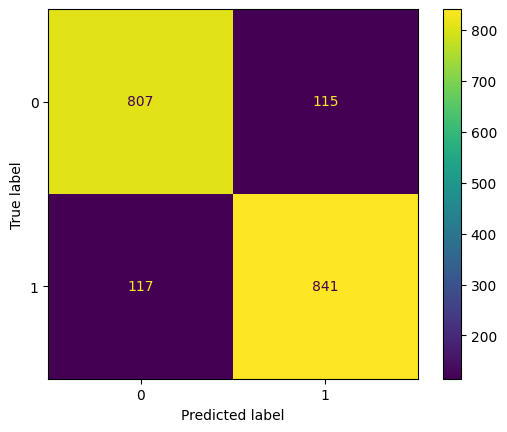

In [19]:
y_pred = model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Precision: ", precision_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()